# Epipolar_Geometry.ipynb
__Description:__ Notebook details how to answer questions for section 2.2.<br>
__Author:__ Matthew Lesko-Krleza<br>
__Course:__ ECSE 415<br>
__Assignment:__ Assignment #3

In [56]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# img_left = cv2.cvtColor(cv2.imread('./Aloe/view1.png'), cv2.COLOR_BGR2RGB)
# img_right = cv2.cvtColor(cv2.imread('./Aloe/view5.png'), cv2.COLOR_BGR2RGB)

img_left = cv2.cvtColor(cv2.imread('./Bowling1/view1.png'), cv2.COLOR_BGR2RGB)
img_right = cv2.cvtColor(cv2.imread('./Bowling1/view5.png'), cv2.COLOR_BGR2RGB)

In [78]:
def drawlines(img1, img2, lines, pts1, pts2):
    """
    Draw epilines. Epilines corresponding to the points in 
    the first image are drawn on the second image.
    :param img1: image on which we draw the epilines for the points
            in img2
    :param lines: corresponding epilines
    """
    # img1 shape
    row, col = img1.shape
    
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    # for each line
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        # pick a random color
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [col, -(r[2]+r[0]*col)/r[1]])
        # draw the lines and the points
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2

### Question 2 Stereo Vision

#### Question 2.2 Epipolar Geometry

Question 2.2.1 Compute matching SIFT keypoints from a stereo image pair

In [58]:
sift_obj = cv2.xfeatures2d.SIFT_create()
bfMatcher = cv2.BFMatcher(cv2.NORM_L2)

keypoints_left, descriptors_left = sift_obj.detectAndCompute(img_left, None)
keypoints_right, descriptors_right = sift_obj.detectAndCompute(img_right, None)

img_keypoints_left = img_left.copy()
img_keypoints_right = img_right.copy()

img_keypoints_left = cv2.drawKeypoints(img_left, keypoints_left, img_keypoints_left, 
                  flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_keypoints_right = cv2.drawKeypoints(img_right, keypoints_right, img_keypoints_right, 
                  flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

matches = bfMatcher.knnMatch(descriptors_left, descriptors_right, k=2)

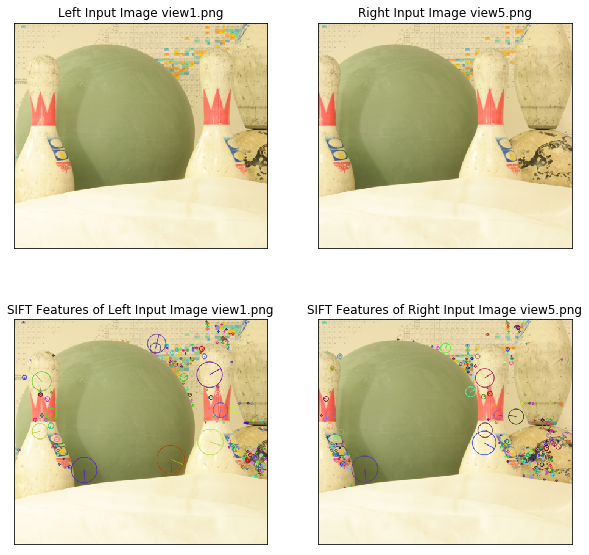

In [59]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(img_left, cmap="gray")
plt.title("Left Input Image view1.png"), plt.xticks([]), plt.yticks([])
plt.subplot(222)
plt.imshow(img_right, cmap="gray")
plt.title("Right Input Image view5.png"), plt.xticks([]), plt.yticks([])
plt.subplot(223)
plt.imshow(img_keypoints_left, cmap="gray")
plt.title("SIFT Features of Left Input Image view1.png"), plt.xticks([]), plt.yticks([])
plt.subplot(224)
plt.imshow(img_keypoints_right, cmap="gray")
plt.title("SIFT Features of Right Input Image view5.png"), plt.xticks([]), plt.yticks([])
plt.show()

Question 2.2.2 Compute epipolar lines for both images

In [79]:
img_left_grey = cv2.cvtColor(img_left.copy(), cv2.COLOR_RGB2GRAY)
img_right_grey = cv2.cvtColor(img_right.copy(), cv2.COLOR_RGB2GRAY)

# ratio test - store the list of best matches from both images
good = []
points_left = []
points_right = []
for i, (m, n) in enumerate(matches):
    if m.distance < 0.6 * n.distance:
        good.append(m)
        points_right.append(keypoints_right[m.trainIdx].pt)
        points_left.append(keypoints_left[m.queryIdx].pt)

# find the Fundamental Matrix
points_left = np.int32(points_left)
points_right = np.int32(points_right)
F, mask = cv2.findFundamentalMat(points_left, points_right, cv2.FM_LMEDS)

# Use only inliers for remaining computations
points_left = points_left[mask.ravel()==1]
points_right = points_right[mask.ravel()==1]

# find epilines
# Epilines corresponding to points in the first image is drawn on the
# second image
lines_left = cv2.computeCorrespondEpilines(points_right, 2, F)
lines_left = lines_left.reshape(-1, 3)
# draw lines
img_left1, img_right1 = drawlines(img_left_grey, img_right_grey, lines_left, points_left, points_right)

lines_right = cv2.computeCorrespondEpilines(points_left, 1, F)
lines_right = lines_right.reshape(-1, 3)
# draw lines
img_right2, img_left2 = drawlines(img_right_grey, img_left_grey, lines_right, points_right, points_left)

Display epipolar lines for both images

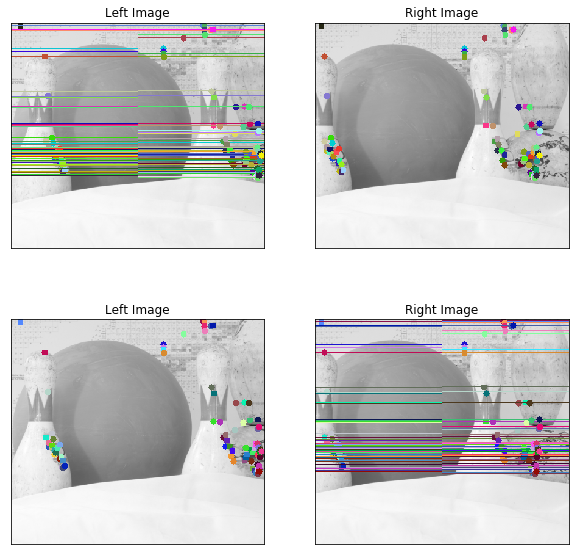

In [95]:
plt.figure(figsize=(10, 10))
plt.subplot(221), plt.imshow(img_left1, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(img_right1, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.subplot(223), plt.imshow(img_left2, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(224), plt.imshow(img_right2, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.show()

Question 2.2.3 Pick any one keypoint in the right image which doesn't have a correct match in the left image, and is not on the corresponding epipolar line. Extract a patch of size (5 x 5) around the keypoint in the right image.

As one can see, the match all the way at the top left corner of the right image has to be an incorrect match, because translating the left image's camera to the right would necessarily remove that patch.

In [81]:
def extractPatch(x, y, img):
    return img[y - 2 : y + 3, x - 2 : x + 3]

def computeSSD(a, b):
    return np.float64(np.sum((a - b) ** 2))

In [96]:
incorrect_point = 0

x_right, y_right = points_right[incorrect_point]
print(x_right, y_right)

patch_right = extractPatch(x_right, y_right, img_right_grey)
print(patch_right)

10 6
[[219 213 214 213 219]
 [195 190 190 188 195]
 [177 154 156 158 179]
 [180 167 165 171 180]
 [180 177 178 179 181]]


Question 2.2.4 Match the extracted patch using SSD with every patch along the corresponding epipolar line in the left image.

In [97]:
patch_ssd = []

for x in range(2, img_left.shape[1] - 2):
    y = int(lines_left[incorrect_point, 0] * x + lines_left[incorrect_point, 2])
    patch_left = extractPatch(x, y, img_left_grey)
    patch_ssd.append(computeSSD(patch_left, patch_right))

Question 2.2.5 Plot SSD values. Find the matching point with minimum SSD value.

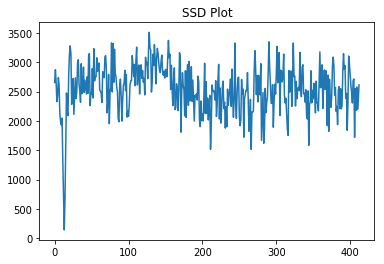

Minimum SSD value:	140.0
Left Image:	(15, 6) 	 Right image:	(10, 6)


In [98]:
img_display_left = img_left.copy()
img_display_right = img_right.copy()

plt.title("SSD Plot")
plt.plot(patch_ssd)
plt.show()

# argmin is offset by 2 compared to real x value
min_left_x = np.argmin(patch_ssd) + 2
min_left_y = int(lines_left[incorrect_point, 0] * min_left_x + lines_left[incorrect_point, 2])

print(str.format("Minimum SSD value:\t{}", np.min(patch_ssd) ))
print(str.format("Left Image:\t({}, {}) \t Right image:\t({}, {})", min_left_x, min_left_y, x_right, y_right))

Display found matching points in both images.

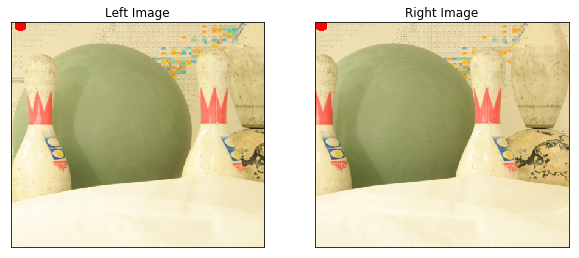

In [99]:
img_display_left = cv2.circle(img_display_left, (min_left_x, min_left_y), 10, (255, 0, 0), -1)
img_display_right = cv2.circle(img_display_right, (x_right, y_right), 10, (255, 0, 0), -1)

plt.figure(figsize=(10,10))
plt.subplot(121), plt.imshow(img_display_left)
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_display_right)
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.show()

Question 2.2.5 Did you find exactly one matching point with lowest SSD or multiple? Is the found matching point correct one? Explain why.

Question 2.2.6 Suppose you found multiple matches in the previous question. What constraint(s) could be imposed on the matching algorithm to and a single match?

Question 2.2.7 Suppose you found exactly one match with the lowest SSD, but it is incorrect one. What constraint(s) could be imposed to find a correct match?